In [1]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import json

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(sys.version)
with open('/kaggle/input/arc-prize-2025/sample_submission.json', 'r') as f:
    data = json.load(f)
    print(data)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suyambhoo.v4.0.0019/pytorch/4.0.0019/1/best_model.4.0.0019chkpt
/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2025/sample_submission.json
/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json
3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
{'00576224': [{'attempt_1': [[0, 0], [0, 0]], 'attempt_2': [[0, 0], [0, 0]]}], '007bbfb7': [{'attempt_1': [[0, 0], [0, 0]], 'attempt_2': [[0, 0], [0, 0]]}], '009d5c81': [{'attempt_1': [[0, 0], [0, 0]], 'attempt_2': [[0, 0], [0, 0]]}], '00d62c1b': [{'attempt_1': [[0, 0], [0, 0]], 'attempt_2': [[0, 0], [0, 0]]}], '00dbd492': [{'attempt_1': [[0, 0], [0, 0]], 'attempt_2': [[0, 0], [0, 0]]}], '017c7c7b': [{'attempt_1': [[0, 0], [0, 0]], 'attempt_2': [[0, 0], [0, 0]]}], '025d127b': [{'attempt_1': [[0, 0], [0, 0]

In [2]:
%matplotlib inline

Using device: cpu
Loading ARC AGI data...
Loaded 240 training pairs and 240 test inputs.
00576224
[[3, 2], [7, 8]]
[[8, 6], [6, 4]]
[[8, 6, 8, 6, 8, 6],
 [6, 4, 6, 4, 6, 4],
 [6, 8, 6, 8, 6, 8],
 [4, 6, 4, 6, 4, 6],
 [8, 6, 8, 6, 8, 6],
 [6, 4, 6, 4, 6, 4]]
########################################
Success!
array([[3, 2, 3, 2, 3, 2],
       [7, 8, 7, 8, 7, 8],
       [2, 3, 2, 3, 2, 3],
       [8, 7, 8, 7, 8, 7],
       [3, 2, 3, 2, 3, 2],
       [7, 8, 7, 8, 7, 8]])
########################################
007bbfb7
[[7, 0, 7], [7, 0, 7], [7, 7, 0]]
[[0, 7, 7], [7, 7, 7], [0, 7, 7]]
[[0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 7, 7, 0, 7, 7, 0, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7],
 [0, 7, 7, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7],
 [0, 0, 0, 7, 7, 7, 7, 7, 7],
 [0, 0, 0, 0, 7, 7, 0, 7, 7]]
########################################
Success!
array([[7, 0, 7, 0, 0, 0, 7, 0, 7],
       [7, 0, 7, 0, 0, 0, 7, 0, 7],
       [7, 7, 0, 0,

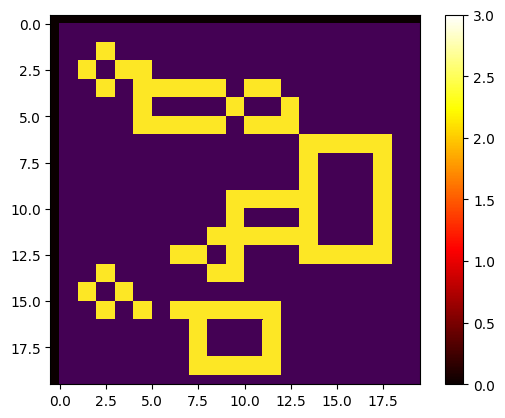

In [3]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pprint import pprint


class PatternTransformer:
    """Learns a transformation from input_like -> output_like and applies it to new inputs.

    The transformer currently supports:
    - Per-value color remapping (0..9)
    - Rotations (0, 90, 180, 270 degrees)
    - Flips (horizontal, vertical)
    - Integer zooming (nearest-neighbor upscaling)
    - Integer shrinking (block-mode downscaling)
    Fallbacks keep the input unchanged when no reliable rule is learned.
    """

    def __init__(self):
        # Learned parameters
        self.color_map = None  # dict[int,int]
        self.rotation_k = 0  # number of 90deg rotations
        self.flip_h = False
        self.flip_v = False
        # Super Kron Broadcast
        self.skb = False
        # Tile and Rotate
        self.t_n_r = False
        self.tile_by = ()  # (3, 3)
        self.rows_to_roll = []  # [2, 3]
        # Learned target output shape (from training output_like)
        self.target_h = None
        self.target_w = None
        self.learned_background = None  # optional background color inferred from output_like

    @staticmethod
    def _mode(values: np.ndarray) -> int:
        if values.size == 0:
            return 0
        vals, counts = np.unique(values, return_counts=True)
        return int(vals[np.argmax(counts)])

    def apply_geom(self, arr: np.ndarray, rot_k: int, fh: bool, fv: bool) -> np.ndarray:
        x = np.rot90(arr, k=rot_k)
        if fh:
            x = np.fliplr(x)
        if fv:
            x = np.flipud(x)
        return x

    def super_kron_broadcast(self, arr: np.ndarray) -> np.ndarray:
        b = arr > 0
        if len(arr[b]) == 0:
            return arr
        b = arr[b][0]
        b = arr == b
        b_arr = arr.copy()
        b_arr[b] = 1
        arr = np.kron(arr, b_arr)
        return arr

    def tile_and_roll(self, arr: np.ndarray, shift: int = 1, axis: int = 1) -> np.ndarray:
        arr = np.tile(arr, self.tile_by)
        arr[self.rows_to_roll] = np.roll(arr[self.rows_to_roll], shift=shift, axis=axis)
        return arr
        
    def fit(self, input_like, output_like) -> None:
        self.input_like = np.array(input_like)
        self.output_like = np.array(output_like)

        # Default background as the most common color in self.output_like
        self.learned_background = self._mode(self.output_like)

        in_h, in_w = self.input_like.shape
        out_h, out_w = self.output_like.shape
        self.target_h = out_h
        self.target_w = out_w

        # Search over geometric transforms and integer scaling to best align to self.output_like
        rotations = [0, 1, 2, 3]  # multiples of 90 degrees
        flip_options = [(False, False), (True, False), (False, True), (True, True)]

        # for rot in rotations:
        #     for fh, fv in flip_options:
        #         geom = apply_geom(self.input_like, rot, fh, fv)
        #         gh, gw = geom.shape

        self.skb = np.array_equal(self.output_like, self.super_kron_broadcast(self.input_like))

        if not self.skb:
            self.tile_by = (3, 3)
            self.rows_to_roll = [2, 3]
            self.t_n_r = np.array_equal(self.output_like, self.tile_and_roll(self.input_like))
            if not self.t_n_r:
                self.tile_by = ()
                self.rows_to_roll = []

    def predict(self, input_matrix) -> np.ndarray:
        input = np.array(input_matrix)
        input_like = self.input_like
        output_like = self.output_like
        
        b = output_like == input_like[0][0]
        pred = np.zeros_like(output_like)

        # 1) Super Kron Broadcast
        if self.skb:
            return self.super_kron_broadcast(input)
        # 2) Tile And Roll
        elif self.t_n_r:
            return self.tile_and_roll(input)
        elif input.shape == output_like.shape:
            for i in range(1, 10):
                ci = input_like == i
                if np.any(ci):
                    cix = ci.copy()
                    ccix = np.nan
                    ci = i
                    for j in range(1, 10):
                        if j == i:
                            continue
                        cci = input_like == j
                        if np.any(cci):
                            ccix = cci.copy()
                            cci = j
                            break
                    try:
                        do = output_like[cix]
                        do = do[0]
                        if isinstance(ccix, np.ndarray):
                            ddo = output_like[ccix]
                            ddo = ddo[0]
                        else:
                            for j in range(1, 10):
                                if j == ci:
                                    continue
                                ddo = output_like == j
                                if np.any(ddo):
                                    ddx = ddo.copy()
                                    ddo = j
                                    break
                        p = input == ci
                        if isinstance(ccix, np.ndarray):
                            pp = input == cci
                        pred = input.copy()
                        pred[p] = do
                        if isinstance(ccix, np.ndarray):
                            pred[pp] = ddo
                        else:
                            pred[ddx] = ddo
                    except Exception as e:
                        print("Exception...", e)
                    return pred
        elif input.shape[1] == output_like.shape[1]:
            for i in range(1, 10):
                ci = input_like == i
                if np.any(ci):
                    ci = np.vstack([ci, ci[:output_like.shape[0]-input.shape[0],:]])
                    if output_like.shape != ci.shape:
                        break
                    do = output_like[ci]
                    do = do[0]
                    for j in range(1, 10):
                        p = input == j
                        if output_like.shape[0] > input.shape[0]:
                            p = np.vstack([p, p[:output_like.shape[0]-input.shape[0],:]])
                        elif input.shape[0] > output_like.shape[0]:
                            p = p[:input.shape[0]-output_like.shape[0]]
                        if np.any(p):
                            pred[p] = do
                            break
            return pred
        elif input.shape[0] > output_like.shape[0] and input.shape[1] > output_like.shape[1]:
            return np.zeros([self.target_h, self.target_w])
        else:
            return np.zeros([self.target_h, self.target_w])

def load_arc_data(json_path):
    """Load ARC AGI data from JSON file"""
    with open(json_path, 'r') as f:
        data = json.load(f)

    training_pairs = {}  # Dict of problem_id and corresponding (input_tensor, output_tensor)
    testing_inputs = {}  # Dict of problem_id and corresponding input_tensors

    first = True
    first_problem_id = None
    
    for problem_id, problem in data.items():
        # Train data
        for pair in problem['train']:
            if first:
                first_problem_id = problem_id
                # print("First Problem ID:", first_problem_id)
                # print("First Pair:")
                # pprint(pair)
            inp = pair['input']
            out = pair['output']
            if first:
                first = False
            training_pairs[problem_id] = (inp, out)
            if first:
                pprint(training_pairs)
        # Test data
        for test_case in problem['test']:
            inp = test_case['input']
            testing_inputs[problem_id] = inp

    return first_problem_id, training_pairs, testing_inputs

def build_output(input, input_like, output_like):
    """Deprecated: kept for compatibility; delegates to PatternTransformer."""
    transformer = PatternTransformer()
    transformer.fit(input_like, output_like)
    return transformer.predict(input)

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    print("Loading ARC AGI data...")
    first_problem_id, training_pairs, testing_inputs = load_arc_data('/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json')
    print(f"Loaded {len(training_pairs)} training pairs and {len(testing_inputs)} test inputs.")
    submission = {}
    counter = 0
    for key, val in training_pairs.items():
        print(key)
        test_input = testing_inputs[key]
        train_in, train_out = val

        pprint(test_input)
        pprint(train_in)
        pprint(train_out)

        # Learn transformation from training example
        transformer = PatternTransformer()
        transformer.fit(train_in, train_out)

        # Predict on the provided test input
        pred = transformer.predict(test_input)

        submission[key] = [{"attempt_1": pred.tolist() if isinstance(pred, np.ndarray) else [0]}]
        counter += 1
        print("#"*40)
        print("Success!")
        pprint(pred)
        print("#"*40)

    test_input = testing_inputs['00d62c1b']
    pprint(test_input)
    plt.pcolor(test_input)
    plt.imshow(test_input, cmap=plt.cm.hot)
    plt.colorbar()
    
    # Write the data to a file with pretty-printing
    with open("submission.json", "w") as submission_file:
        json.dump(submission, submission_file)
    print(f"Finished - {counter}!")
    print(submission)

if __name__ == "__main__":
    main()